In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import gc
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
import lightgbm

In [57]:
sns.set(rc={'figure.figsize':(12,9)})
sns.set_palette("husl", 9)

In [60]:
#importing dataset
df_raw = pd.read_csv("train.csv")
df_raw.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [63]:
#shape of dataframe
df_raw.shape

(40428967, 24)

The dataset has about 40M records across 24 predictor variables.

In [42]:
df_raw_sample = df_raw.sample(frac=0.05, replace=False, random_state = 666)
df_raw_sample.shape

(2021448, 24)

In [64]:
df_raw_sample['click'].value_counts()

0    1678791
1     342657
Name: click, dtype: int64

In [65]:
len(df_raw_sample[df_raw_sample['click'] == 1])

342657

In [66]:
df_raw_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2021448 entries, 10584553 to 14334394
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   click             int64  
 2   hour              int64  
 3   C1                int64  
 4   banner_pos        int64  
 5   site_id           object 
 6   site_domain       object 
 7   site_category     object 
 8   app_id            object 
 9   app_domain        object 
 10  app_category      object 
 11  device_id         object 
 12  device_ip         object 
 13  device_model      object 
 14  device_type       int64  
 15  device_conn_type  int64  
 16  C14               int64  
 17  C15               int64  
 18  C16               int64  
 19  C17               int64  
 20  C18               int64  
 21  C19               int64  
 22  C20               int64  
 23  C21               int64  
dtypes: float64(1), int64(14), object(9)
memory usage: 465.6+ MB


There are 9 predictor variables which are of object type and id which is of float type. While, rest of the predictors are integer type.

In [67]:
df_raw_sample[df_raw_sample.duplicated(keep=False)]

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21


In [68]:
df_raw_sample.isna().any()

id                  False
click               False
hour                False
C1                  False
banner_pos          False
site_id             False
site_domain         False
site_category       False
app_id              False
app_domain          False
app_category        False
device_id           False
device_ip           False
device_model        False
device_type         False
device_conn_type    False
C14                 False
C15                 False
C16                 False
C17                 False
C18                 False
C19                 False
C20                 False
C21                 False
dtype: bool

The dataset has no missing or NaN values hence imputation is not required.

In [69]:
for i in df_raw_sample.select_dtypes(exclude = np.number).columns:
    x = df_raw_sample[i].value_counts()
    print("Column name is:",i,"and it value is:",x)
    print()

Column name is: site_id and it value is: 85f751fd    729597
1fbe01fe    323752
e151e245    131715
d9750ee7     47785
5b08c53b     45470
             ...  
d240c6be         1
95b98d6a         1
53837936         1
0ec2b8a9         1
719302d2         1
Name: site_id, Length: 3042, dtype: int64

Column name is: site_domain and it value is: c4e18dd6    756494
f3845767    323752
7e091613    166138
7687a86e     64298
98572c79     49455
             ...  
da1840ac         1
3655e22b         1
6992985d         1
4994a89a         1
f49c7a79         1
Name: site_domain, Length: 3521, dtype: int64

Column name is: site_category and it value is: 50e219e0    826896
f028772b    633433
28905ebd    368265
3e814130    152439
f66779e6     12488
75fa27f6      8023
335d28a8      6975
76b2941d      5337
c0dd3be3      2041
72722551      1442
dedf689d      1227
70fb0e29      1173
0569f928       887
8fd0aea4       382
a818d37a       170
42a36e14       108
e787de0e        58
bcf865d9        55
5378d028        2

In [70]:
df_raw_sample["device_type"].value_counts()

1    1864898
0     111266
4      38744
5       6536
2          4
Name: device_type, dtype: int64

In [71]:
del df_raw

In [72]:
df_raw_sample.nunique()

id                  2021448
click                     2
hour                    240
C1                        7
banner_pos                7
site_id                3042
site_domain            3521
site_category            22
app_id                 3929
app_domain              242
app_category             27
device_id            281246
device_ip            971277
device_model           5790
device_type               5
device_conn_type          4
C14                    2366
C15                       8
C16                       9
C17                     426
C18                       4
C19                      67
C20                     161
C21                      60
dtype: int64

<AxesSubplot:xlabel='click', ylabel='count'>

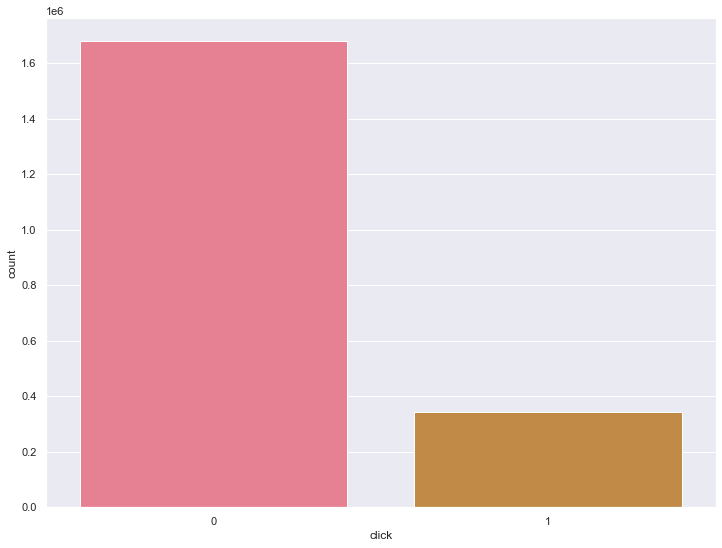

In [73]:
sns.countplot(x="click", data=df_raw_sample)

As we can see the dataset is heavily imbalanced. We can solove this problem by either Undersampling or Oversampling. Since the dataset is particularly huge, undersampling is a clear choice.

In [74]:
df_raw_sample['device_type'].value_counts()

1    1864898
0     111266
4      38744
5       6536
2          4
Name: device_type, dtype: int64

<AxesSubplot:xlabel='device_type', ylabel='count'>

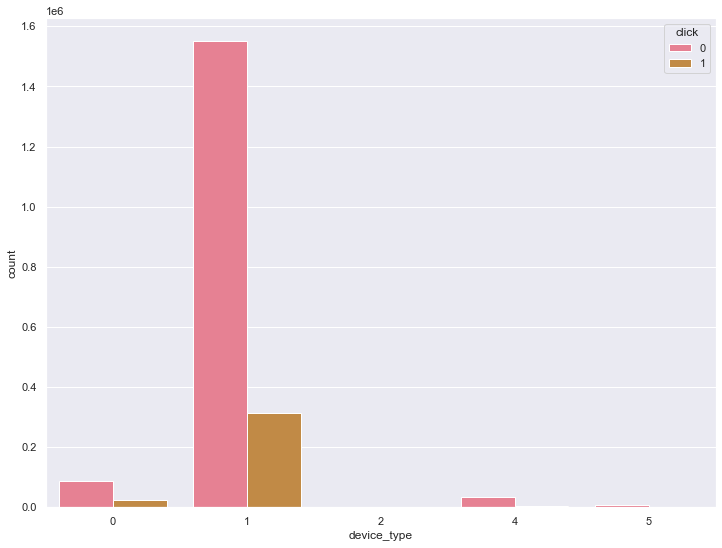

In [75]:
sns.countplot(x = "device_type", data = df_raw_sample, hue = "click")

Most of the clicks and ads shown were from device_type 1. Followed by device_type 0.

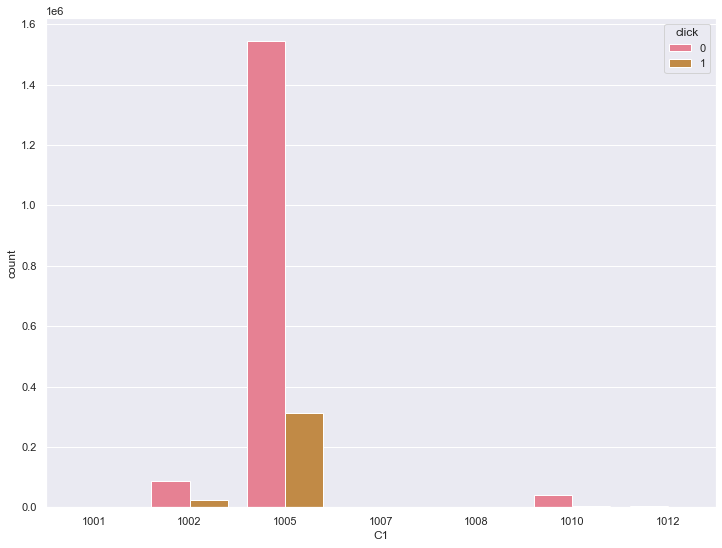

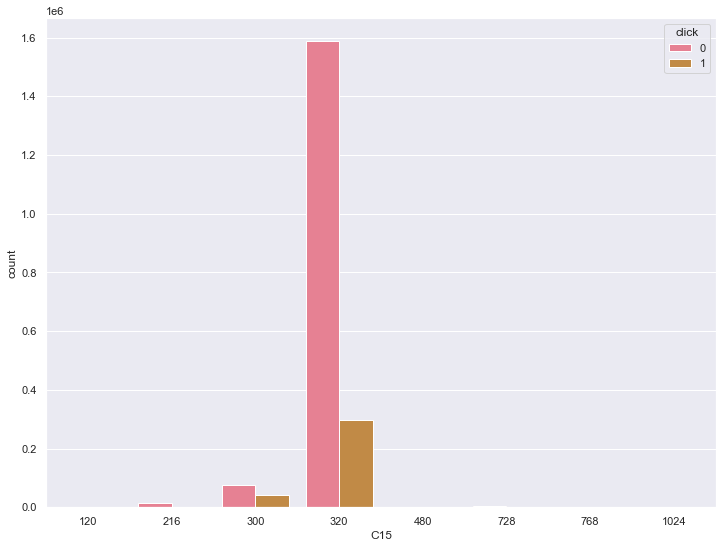

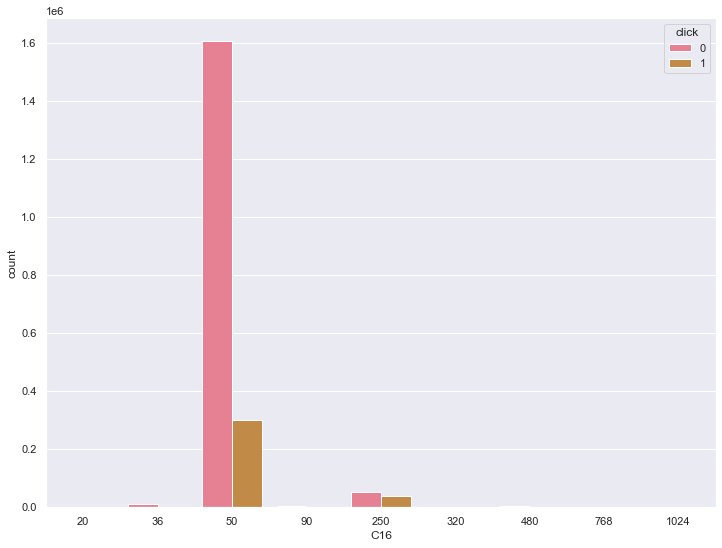

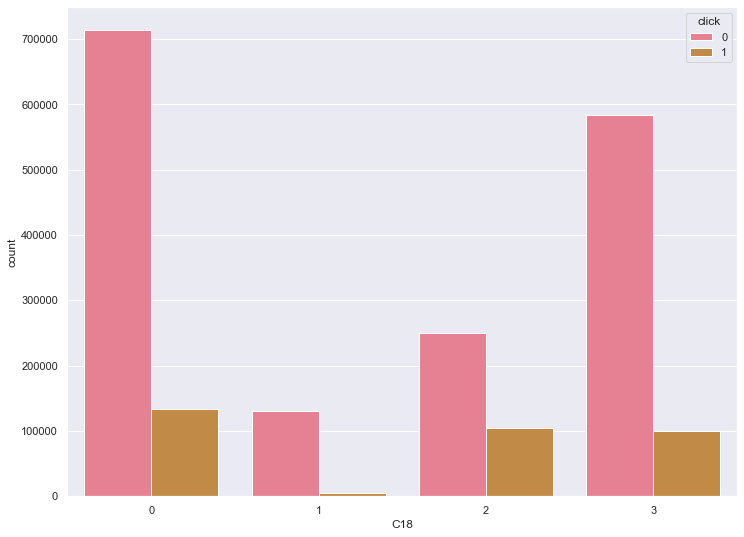

In [76]:
import matplotlib.pyplot as plt
cols=['C1', 'C15', 'C16', 'C18']
for col in cols:
    plt.figure()
    sns.countplot(x=col, data=df_raw_sample, hue = 'click')

Most of the clicks were from:<br>
1) C1 1005 category <br>
2) C15 320 category <br> 
3) C16 50 category <br> 
4) C18 0,2,3 category <br>

In [77]:
df_test_raw = pd.read_csv("test.csv")
df_test_raw.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
2,1.000055e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
3,1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,...,1,0,18648,320,50,1092,3,809,100156,61
4,1.000138e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,...,1,0,23160,320,50,2667,0,47,-1,221


In [78]:
df_test_raw.shape

(4577464, 23)

In [88]:
df_test_sample = df_test_raw.sample(frac=0.442, replace=False, random_state = 666)
df_test_sample.shape

(2023239, 23)

In [89]:
df_raw_sample.shape

(2021448, 24)

In [100]:
train_contingency = pd.crosstab(df_raw_sample['C14'], columns = 'count')

In [101]:
test_contingency = pd.crosstab(df_test_sample['C14'], columns = 'count')

In [104]:
from scipy.stats import chi2_contingency, chi2

stat, p, dof, expected = chi2_contingency()
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

dof=0
[[4.278e+03]
 [7.000e+00]
 [3.961e+03]
 ...
 [4.200e+01]
 [4.300e+01]
 [2.000e+00]]
probability=0.950, critical=nan, stat=0.000
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)


In [106]:
df_test_sample.to_csv("test_sample.csv")

In [107]:
df_raw_sample.to_csv("train_sample.csv")